<span style="color:magenta">Group Names:</span>

* Zhe HUANG
* Lanshi FU
* Pierre QIU

# Hands-On NLP

## Class 2

- Embeddings from scratch

- Classifications with embeddings

In [1]:
import re
import unicodedata
from collections import Counter
from pathlib import Path

import matplotlib as mpl
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
from nltk.tokenize import word_tokenize
from sklearn import decomposition
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.naive_bayes import BernoulliNB, GaussianNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from tqdm.notebook import tqdm

In [2]:
tqdm.pandas()

nltk.download("punkt")

sns.set_style("darkgrid")
sns.set_context("notebook")

pd.set_option("display.precision", 2)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\qiu87\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
%config InlineBackend.figure_format="retina"  # For high DPI display

# %load_ext blackcellmagic

In [4]:
DATA = Path()

TEXT_P = DATA / "texts"

CORPORA = [
    "mythology",
    "woodworking",
    "robotics",
    "hsm",
    "health",
    "portuguese",
]

EPS = np.finfo(float).eps

In [5]:
TEXT_P.mkdir(exist_ok=True)

# Getting the data

In [6]:
corpora = {}
stats = []

for corpus in tqdm(CORPORA):
    print(corpus)
    texts = []
    for fp in (TEXT_P / corpus).glob("*.txt"):
        with fp.open(encoding='utf-8') as f:
            texts.append(f.read())

    corpora[corpus] = "".join(texts)

    stats.append(
        {
            "corpus": corpus,
            "files_n": len(texts),
            "chars_n": len(corpora[corpus]),
        }
    )

df = pd.DataFrame.from_records(stats, index=["corpus"])
df["text"] = [corpora[corpus] for corpus in corpora]
df

  0%|          | 0/6 [00:00<?, ?it/s]

mythology
woodworking
robotics
hsm
health
portuguese


,files_n,chars_n,text
corpus,,,
mythology,1428,4689305,Q:\n\nWhere can I find the earliest literary c...
woodworking,2461,6729416,Q:\n\nHow do I sharpen a chisel/plane blade?\n...
robotics,2981,7254006,Q:\n\nWhat is the right approach to write the ...
hsm,2329,7364214,Q:\n\nCauchy's undead theory\n\nA well known u...
health,3412,9148631,Q:\n\nWhat are these lines in teeth?\n\nThe fo...
portuguese,1840,4415251,"Q:\n\nComo usar corretamente ""por que"", ""por q..."


### Tokenizing

In [7]:
# If your machine is slow, pickeling allows to go faster next time.

tokens_fp = DATA / "tokens.pkl"
try:
    tokens = pd.read_pickle(tokens_fp)
except FileNotFoundError:
    tokens = df.text.progress_map(word_tokenize)
    tokens.to_pickle(tokens_fp)

In [8]:
df["tokens"] = tokens
df["tokens_n"] = df.tokens.map(len)
df["types_n"] = df.tokens.map(set).map(len)
df

,files_n,chars_n,text,tokens,tokens_n,types_n
corpus,,,,,,
mythology,1428,4689305,Q:\n\nWhere can I find the earliest literary c...,"[Q, :, Where, can, I, find, the, earliest, lit...",942599,51253
woodworking,2461,6729416,Q:\n\nHow do I sharpen a chisel/plane blade?\n...,"[Q, :, How, do, I, sharpen, a, chisel/plane, b...",1390532,32318
robotics,2981,7254006,Q:\n\nWhat is the right approach to write the ...,"[Q, :, What, is, the, right, approach, to, wri...",1526904,53833
hsm,2329,7364214,Q:\n\nCauchy's undead theory\n\nA well known u...,"[Q, :, Cauchy, 's, undead, theory, A, well, kn...",1445136,62464
health,3412,9148631,Q:\n\nWhat are these lines in teeth?\n\nThe fo...,"[Q, :, What, are, these, lines, in, teeth, ?, ...",1714931,66006
portuguese,1840,4415251,"Q:\n\nComo usar corretamente ""por que"", ""por q...","[Q, :, Como, usar, corretamente, ``, por, que,...",907242,60282


# Vectorization

#### 🚧 TODO: Think about how to vectorize text

- Try counting words in the stackoverflow corpus based on a given vocabulary

- Apply reduction techniques to reduce the dimensionality to 2 dimensions (e.g., PCA)

- Plot the 2D vectors

In [9]:
words = (
    "myth,wood,robot,history,science,mathematics,health,portuguese,o".split(",")
)
wc_df = pd.DataFrame(index=df.index)

In [10]:
# count words
for w in words:
    wc_df[w] = [len([token for token in df.tokens[corpus] if token == w]) for corpus in CORPORA]    
wc_df

,myth,wood,robot,history,science,mathematics,health,portuguese,o
corpus,,,,,,,,,
mythology,769,55,6,179,21,4,18,0,27
woodworking,5,7535,0,18,9,0,48,0,2
robotics,0,21,4895,23,22,43,3,0,63
hsm,26,14,2,921,846,1578,28,1,25
health,46,10,1,207,114,6,1576,1,3
portuguese,2,11,3,13,3,1,8,41,14589


In [11]:
# reduce dimension
pca = decomposition.PCA(n_components=2)
wc_decomposed = pca.fit_transform(wc_df)
print(wc_decomposed)

[[-2172.11807505 -1204.418861  ]
 [-3185.9537627   5969.32416384]
 [-2446.45160229 -2479.24649585]
 [-2214.38228703 -1352.87210068]
 [-2215.38517532 -1297.79394626]
 [12234.29090238   365.00723994]]


[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]


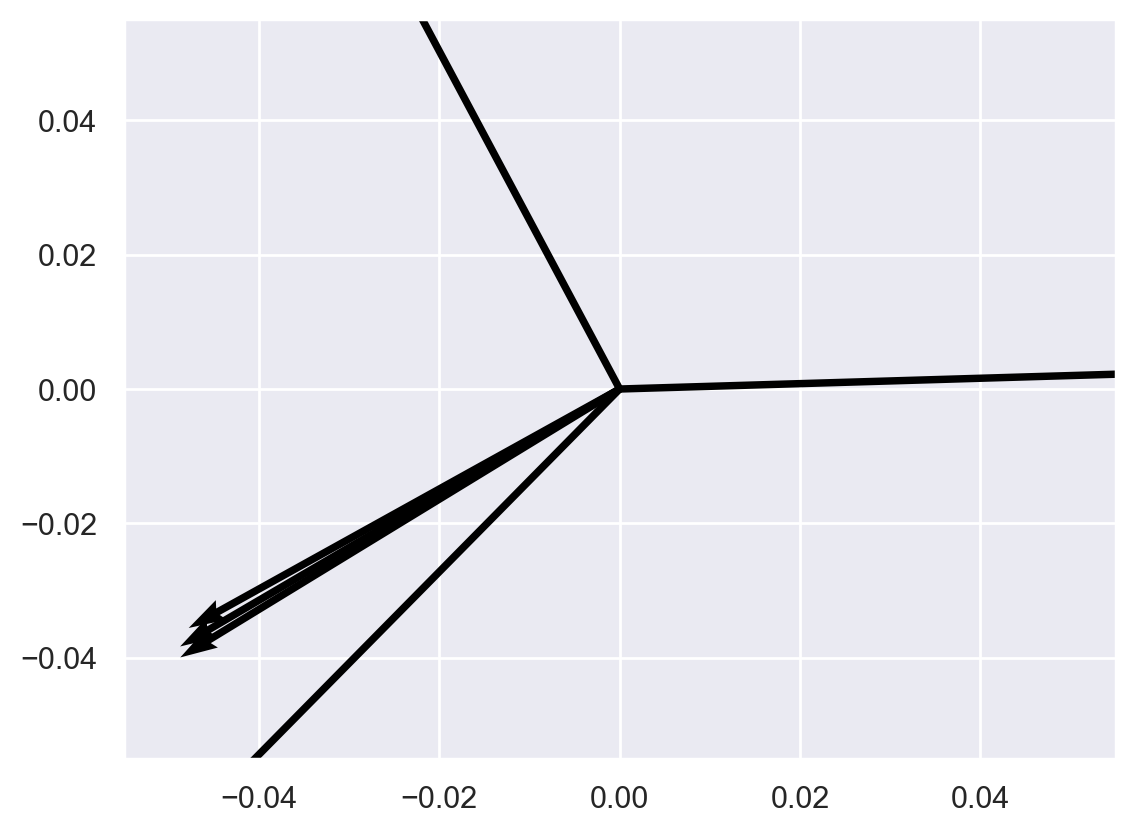

In [12]:
#plot 2-D vectors
origin = np.zeros((2, len(corpora)))
print(origin)

plt.quiver(*origin, wc_decomposed[:,0], wc_decomposed[:,1], scale = 5000)
plt.show()

### Bag of words

#### 🚧 TODO: Implement another bag of words vectorizer model on the corpus

*   This time using [sklearn's `CountVectorizer`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html)

*   Try first the provided example in the `CountVectorizer` documentation

    *   Try with and without the n-gram parameter <br/><br/>

*   Then try to vectorize the stackoverflow corpus using `vocabulary=words`

In [13]:
vectorizer = CountVectorizer(vocabulary=words)
word_freq_matrix = vectorizer.fit_transform(df.text)

print(word_freq_matrix.toarray())

[[ 867   75    6  307   35    4   23    4    0]
 [   5 8017    1   19   16    0   53    0    0]
 [   0   22 5321   25   33   50    3    2    0]
 [  28   17    2 1513 1174 2095   39    7    0]
 [  55   13    1  242  263    9 2178    4    0]
 [   2   13    3   18    7    3    9 1061    0]]


In [14]:
cv_df = pd.DataFrame(word_freq_matrix.toarray(), index=df.index, columns=words)
cv_df

,myth,wood,robot,history,science,mathematics,health,portuguese,o
corpus,,,,,,,,,
mythology,867,75,6,307,35,4,23,4,0
woodworking,5,8017,1,19,16,0,53,0,0
robotics,0,22,5321,25,33,50,3,2,0
hsm,28,17,2,1513,1174,2095,39,7,0
health,55,13,1,242,263,9,2178,4,0
portuguese,2,13,3,18,7,3,9,1061,0


#### 🚧 TODO: Why is this different? 

- Try to explain

- Give a simple example with the toy corpus below (with the same vocabulary)

In [15]:
test_text = (
    " myth wood wood, wood\n wood- wood: wood= wood+ wood$ robot history science mathematics health portuguese oooo ooo oooo"
    " myth wood robot history science mathematics health portuguese oo oo ooo "
)

test_token = word_tokenize(test_text)
test_token

['myth',
 'wood',
 'wood',
 ',',
 'wood',
 'wood-',
 'wood',
 ':',
 'wood=',
 'wood+',
 'wood',
 '$',
 'robot',
 'history',
 'science',
 'mathematics',
 'health',
 'portuguese',
 'oooo',
 'ooo',
 'oooo',
 'myth',
 'wood',
 'robot',
 'history',
 'science',
 'mathematics',
 'health',
 'portuguese',
 'oo',
 'oo',
 'ooo']

In [16]:
freqs = pd.DataFrame(index=["test_text"],columns=words)
for w in words:
    freqs[w] = test_token.count(w)
freqs

,myth,wood,robot,history,science,mathematics,health,portuguese,o
test_text,2,6,2,2,2,2,2,2,0


In [17]:
vectorizer = CountVectorizer(vocabulary=words,ngram_range=(1,1))
test_freq_matrix = vectorizer.fit_transform([test_text])
test_cv_df = pd.DataFrame(test_freq_matrix.toarray(), index=['test_text'], columns=words)
test_cv_df

,myth,wood,robot,history,science,mathematics,health,portuguese,o
test_text,2,9,2,2,2,2,2,2,0


<span style="color:magenta">
The difference is because CountVectorizer will count those words followed by symbols.(except ',' and '.')    

For example, CountVectorizer will count words like 'wood-', 'wood#' for word 'wood' while 'wood-' will not be counted if  we use word_tokenize. 

</span>

#### 🚧 TODO: Is this difference important?

• Visualize the PCAs of both models

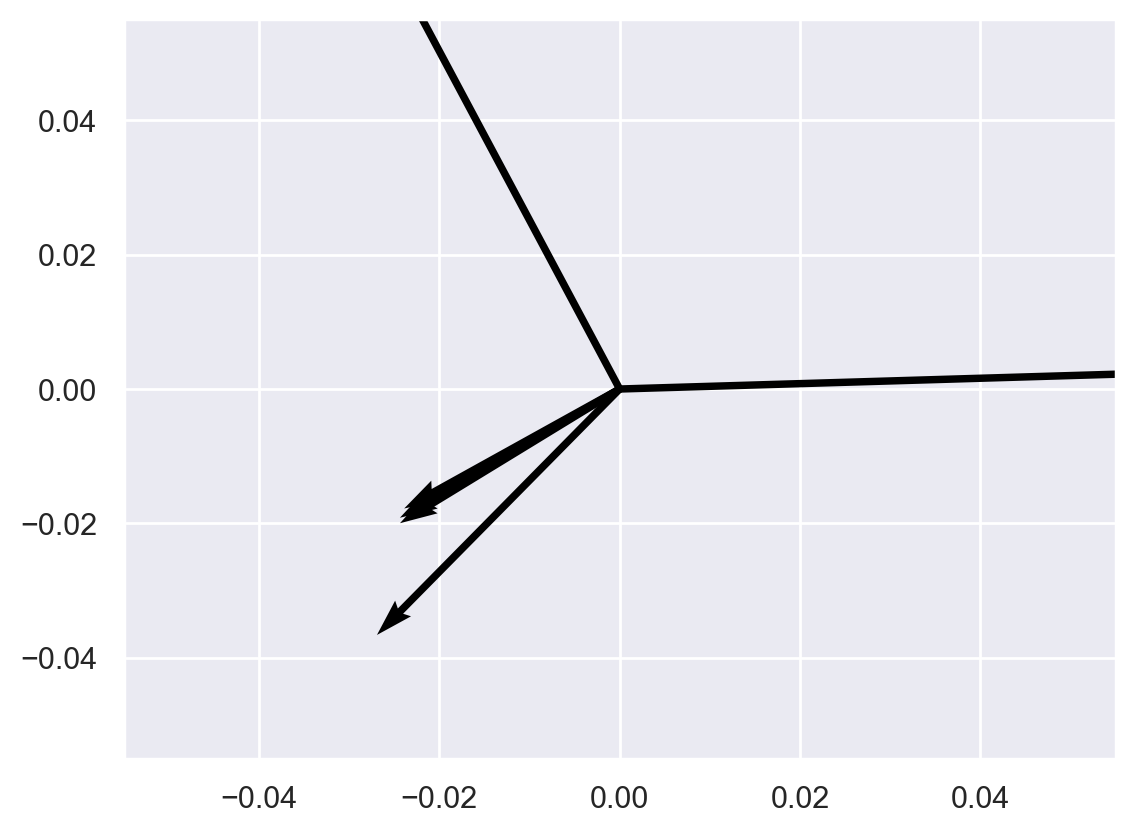

In [18]:
#plot 2-D vectors
plt.quiver(*origin, wc_decomposed[:,0], wc_decomposed[:,1], scale = 10000)
plt.show()

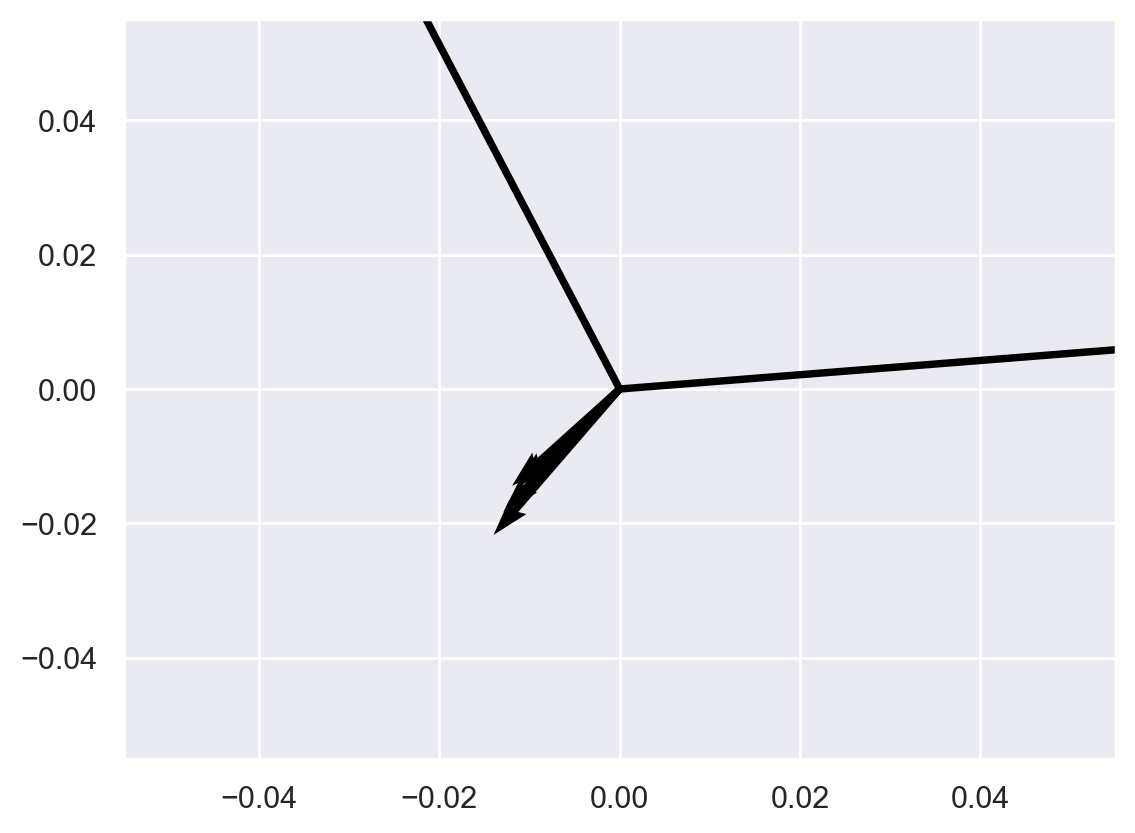

In [19]:
# reduce dimension
cv_decomposed = pca.fit_transform(cv_df)

#plot 2-D vectors
plt.quiver(*origin, cv_decomposed[:,0], cv_decomposed[:,1], scale = 10000)
plt.show()

-----------

## Hold the corpus as individual documents

In [20]:
data = []

for i, corpus in enumerate(tqdm(CORPORA)):
    print(corpus)
    for fp in (TEXT_P / corpus).glob("*.txt"):
        with fp.open(encoding='utf-8') as f:
            text = f.read()
        data.append(
            {
                "id": fp.stem,
                "text": text,
                "category": corpus,
                "cat_id": i,
            }
        )

  0%|          | 0/6 [00:00<?, ?it/s]

mythology
woodworking
robotics
hsm
health
portuguese


In [21]:
doc_df = pd.DataFrame.from_records(data).set_index("id")
doc_df

,text,category,cat_id
id,,,
mythology.stackexchange_0000000001,Q:\n\nWhere can I find the earliest literary c...,mythology,0
mythology.stackexchange_0000000002,Q:\n\nDid the Greeks build temples for all of ...,mythology,0
mythology.stackexchange_0000000003,Q:\n\nDid the Gods and Goddesses in Norse myth...,mythology,0
mythology.stackexchange_0000000005,"Q:\n\nWas the Minotaur a single being, or a ra...",mythology,0
mythology.stackexchange_0000000007,Q:\n\nDid Zeus have any male lovers?\n\nMany o...,mythology,0
...,...,...,...
portuguese.stackexchange_0000009084,"Q:\n\nQual a função sintática de ""pelo organis...",portuguese,5
portuguese.stackexchange_0000009088,"Q:\n\nPrecisa de advérbio após «eis-me», «eis-...",portuguese,5
portuguese.stackexchange_0000009090,Q:\n\nUsing “foram” ― is this correct across s...,portuguese,5


#### 🚧 TODO: Plot (bar) the number of documents per category

In [22]:
n_category = pd.DataFrame(doc_df["category"].value_counts())
n_category.columns = ["n_category"]
n_category

,n_category
health,3412
robotics,2981
woodworking,2461
hsm,2329
portuguese,1840
mythology,1428


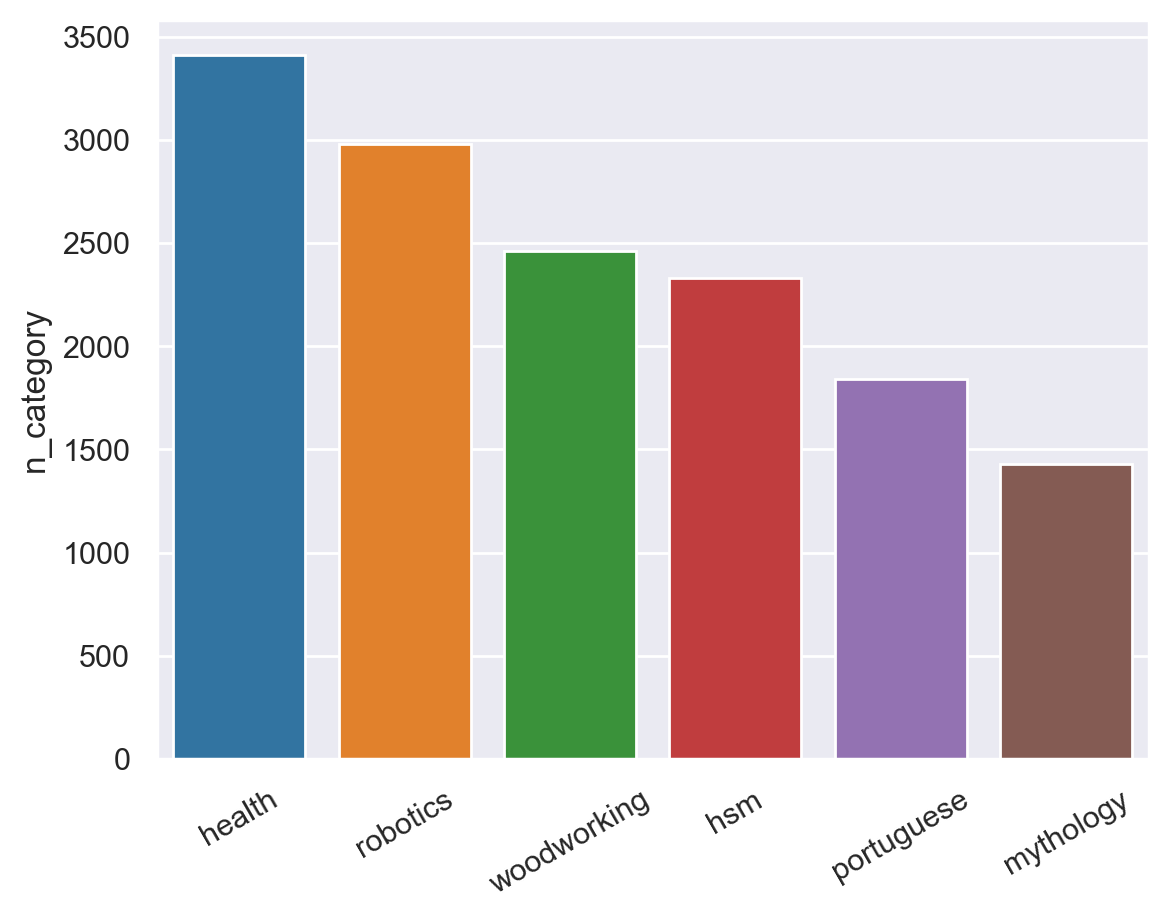

In [23]:
sns.barplot(x=n_category.index, y="n_category", data=n_category)
plt.xticks(rotation=30)
plt.show()

#### 🚧 TODO: Boxplot the number of tokens per document

* With and without outliers

* Shortly explain the different values presented in a boxplot ([Wikipedia](https://en.wikipedia.org/wiki/Box_plot))

* Are the texts of signifcantly different length? Argue shortly.

In [24]:
doc_df["tokens"] = doc_df.text.progress_map(word_tokenize)

  0%|          | 0/14451 [00:00<?, ?it/s]

In [25]:
doc_df["n_tokens"] = doc_df["tokens"].map(len)

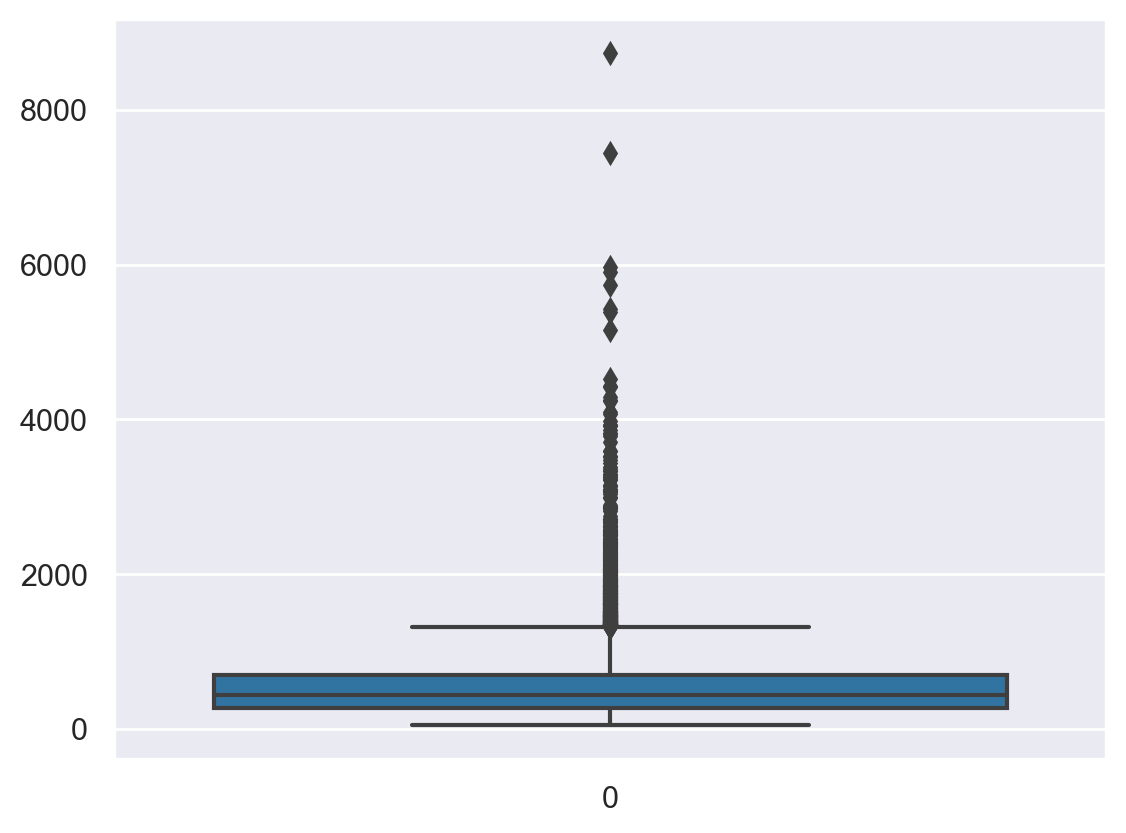

In [26]:
sns.boxplot(data=doc_df["n_tokens"])
plt.show()

<span style="color:magenta">
  
Black dots represent outliers;  

Black lines represent upper/lower whisker;  

Blue box's upper side is maximum while its lower side is minimum;  

Black line in the blue box represents median.  
</span>

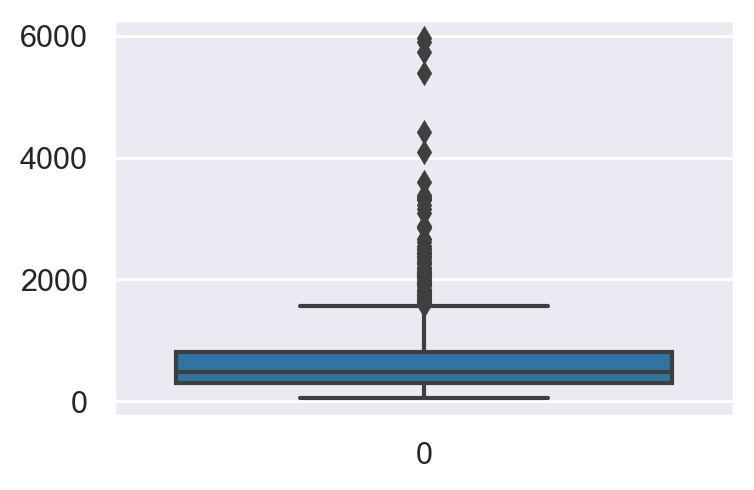

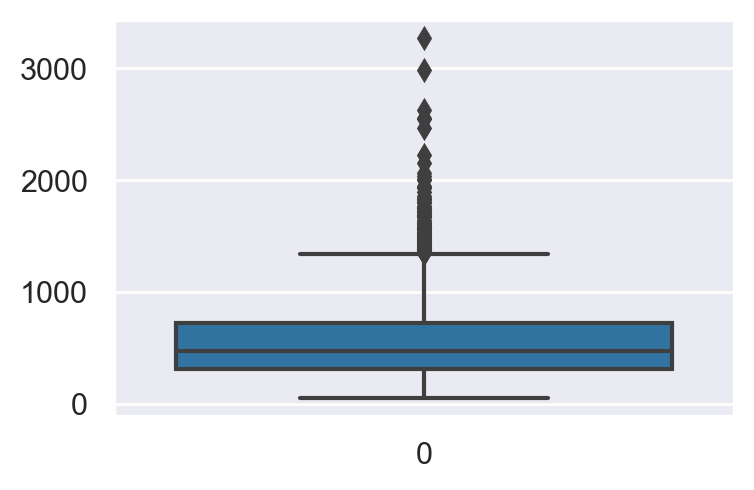

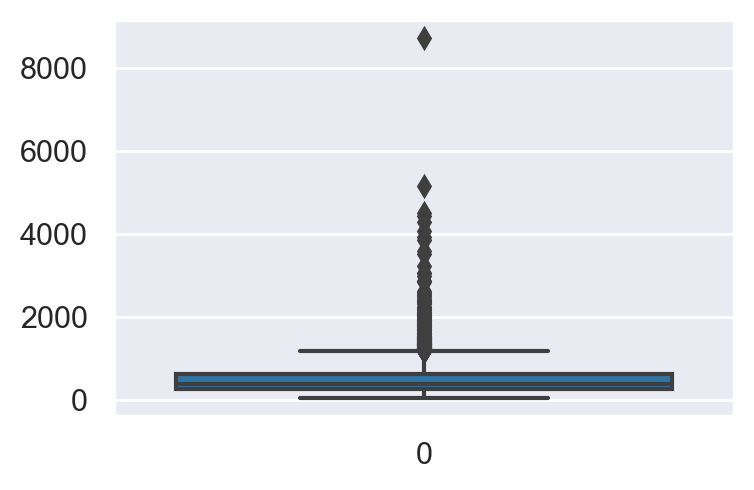

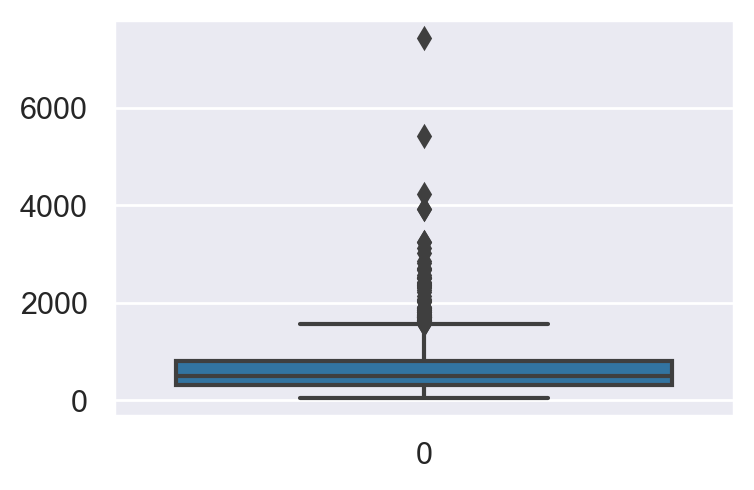

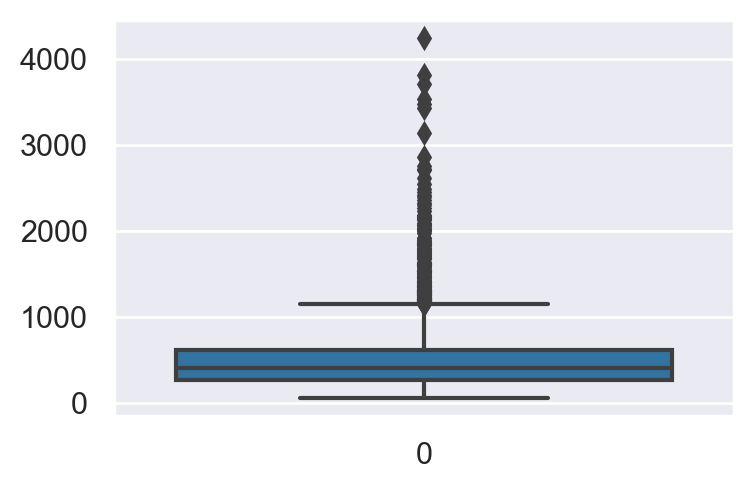

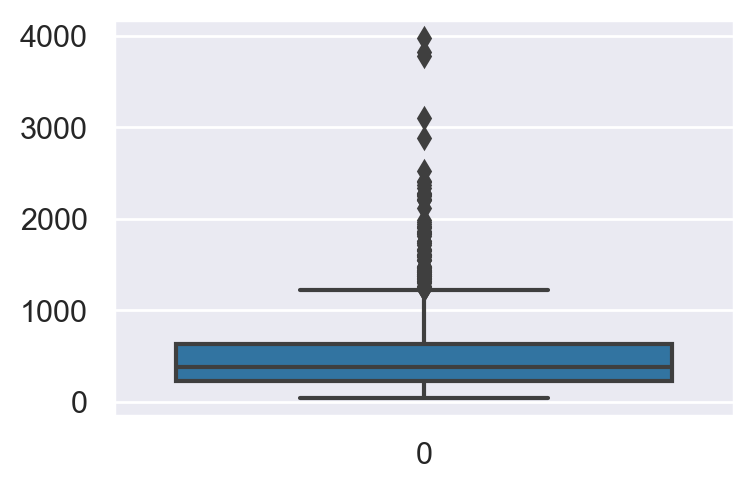

In [27]:
for i,corpus in enumerate(CORPORA):
    plt.figure(figsize=(4, 18))
    plt.subplot(len(CORPORA), 1, i+1)
    sns.boxplot(data=doc_df[doc_df['category']==corpus]["n_tokens"])

<span style="color:magenta">
The majority of texts are not of signifcantly different length.  

But there exist some texts with super long length for every corpus.
</span>

### 🚧 TODO: How to find the crazy long robotics text?

*   Find the index of the longest text

*   Show the content

*   Explain why this text is so long (what does it contain?)

In [28]:
doc_df

,text,category,cat_id,tokens,n_tokens
id,,,,,
mythology.stackexchange_0000000001,Q:\n\nWhere can I find the earliest literary c...,mythology,0,"[Q, :, Where, can, I, find, the, earliest, lit...",221
mythology.stackexchange_0000000002,Q:\n\nDid the Greeks build temples for all of ...,mythology,0,"[Q, :, Did, the, Greeks, build, temples, for, ...",222
mythology.stackexchange_0000000003,Q:\n\nDid the Gods and Goddesses in Norse myth...,mythology,0,"[Q, :, Did, the, Gods, and, Goddesses, in, Nor...",1831
mythology.stackexchange_0000000005,"Q:\n\nWas the Minotaur a single being, or a ra...",mythology,0,"[Q, :, Was, the, Minotaur, a, single, being, ,...",567
mythology.stackexchange_0000000007,Q:\n\nDid Zeus have any male lovers?\n\nMany o...,mythology,0,"[Q, :, Did, Zeus, have, any, male, lovers, ?, ...",328
...,...,...,...,...,...
portuguese.stackexchange_0000009084,"Q:\n\nQual a função sintática de ""pelo organis...",portuguese,5,"[Q, :, Qual, a, função, sintática, de, ``, pel...",1045
portuguese.stackexchange_0000009088,"Q:\n\nPrecisa de advérbio após «eis-me», «eis-...",portuguese,5,"[Q, :, Precisa, de, advérbio, após, «, eis-me,...",475
portuguese.stackexchange_0000009090,Q:\n\nUsing “foram” ― is this correct across s...,portuguese,5,"[Q, :, Using, “, foram, ”, ―, is, this, correc...",429


In [29]:
longests_df = doc_df[doc_df["n_tokens"]==doc_df["n_tokens"].max()]

In [30]:
print(longests_df["text"].values)

['Q:\n\n6DOF Kinematics moveo\n\nI asked on stackoverflow for the DH-Parameter for my robotic arm (moveo bcn3d).\nI also copied the arduino code of Skyentific (YouTuber). Modified it to match my settings but i still does not work. Can someone please help me??? I am getting depressed if this keeps going like that.\nIn the home position, all joints have angle 0.\nIf I tell the forward kinematic that I want the 3rd joint and the 5th joint rotated 90 degrees, the values should be: (224, 0, 280) {x, y, z} should come out + some euler angles (can be ignored for now).\nBut I don\'t understand why these values come out, because the r and d values of the DH matrix are correct(https://stackoverflow.com/questions/67159164/denavit-hartenberg-6dof-moveo-inverse-kinematic-robot-arm?noredirect=1#comment118726837_67159164)\nOutput of the Arduino:\\\ninverse:\n0.00\n0.00\n-0.00\n-180.00\n180.00\n-180.00\nforward:\n-224.00\n0.00\n280.00\n45.00\n180.00\n45.00\nIn this example you can see that the inverse

In [31]:
print(longests_df["tokens"].values)

[list(['Q', ':', '6DOF', 'Kinematics', 'moveo', 'I', 'asked', 'on', 'stackoverflow', 'for', 'the', 'DH-Parameter', 'for', 'my', 'robotic', 'arm', '(', 'moveo', 'bcn3d', ')', '.', 'I', 'also', 'copied', 'the', 'arduino', 'code', 'of', 'Skyentific', '(', 'YouTuber', ')', '.', 'Modified', 'it', 'to', 'match', 'my', 'settings', 'but', 'i', 'still', 'does', 'not', 'work', '.', 'Can', 'someone', 'please', 'help', 'me', '?', '?', '?', 'I', 'am', 'getting', 'depressed', 'if', 'this', 'keeps', 'going', 'like', 'that', '.', 'In', 'the', 'home', 'position', ',', 'all', 'joints', 'have', 'angle', '0', '.', 'If', 'I', 'tell', 'the', 'forward', 'kinematic', 'that', 'I', 'want', 'the', '3rd', 'joint', 'and', 'the', '5th', 'joint', 'rotated', '90', 'degrees', ',', 'the', 'values', 'should', 'be', ':', '(', '224', ',', '0', ',', '280', ')', '{', 'x', ',', 'y', ',', 'z', '}', 'should', 'come', 'out', '+', 'some', 'euler', 'angles', '(', 'can', 'be', 'ignored', 'for', 'now', ')', '.', 'But', 'I', 'do', "

<span style="color:magenta">
This text is very long because it contains much maths formula and codes, which will leads high number of tokens.
</span>

### Vectorizing again

#### 🚧 TODO: See how many features we get if we don't restrict them

* Use again the `CountVectorizer` to vectorize the stackoverflow corpus

  * But use the whole vocabulary of the documents this time (**without** `vocabulary=words`)

  * Tell how many features are obtained

* Then limit the vocabulary to the 5000 most frequent words

* Apply and plot dimensionality reduction to 2 dimensions as prevously

We want something like this:

```python
xs ~ doc_df.text
ys ~ doc_df.cat_id
```

In [32]:
ys = doc_df.cat_id.values

In [33]:
unconstrained_cv = CountVectorizer()
xs = vectorizer.fit_transform(doc_df.text).toarray()

In [34]:
xs.shape

(14451, 9)

In [35]:
xs.max(axis=1)

array([0, 0, 1, ..., 1, 0, 2], dtype=int64)

In [36]:
cv = CountVectorizer(max_features=5000)
xs_limited= cv.fit_transform(doc_df.text).toarray()

In [37]:
xs_limited.shape

(14451, 5000)

In [38]:
xs_limited.max(axis=1)

array([14, 20, 93, ..., 12,  8, 13], dtype=int64)

In [39]:
pca = decomposition.PCA(n_components=2)
xs_decomposed = pca.fit_transform(xs_limited)
print(xs_decomposed)

[[-1.61884441e+01  6.08200033e-02]
 [-1.09236395e+01  1.56587046e-01]
 [ 1.10163281e+02 -2.05877865e-02]
 ...
 [-1.52232238e+01 -2.72675720e-01]
 [-3.53947519e+01 -6.47889791e-02]
 [-2.00863978e+01 -1.97053925e-01]]


In [40]:
xs_decomposed.shape

(14451, 2)

#### 🚧 TODO: Outsider: find that guy!

* Use pandas to find the document corresponding to the outlier

* Print the correspoding text
  
* Tell what it contains (if you could figure it out)

* Remove the corresping raw from the dataframe and redo the dimensional reduction (and plot)

In [41]:
def box_plot_outliers(data):
    q1, q3 = data.quantile(.25), data.quantile(.75)
    iqr = q3 - q1
    # lower whisker
    low = q1 - iqr*1.5
    # upper whisker
    up = q3 + iqr*1.5
    # outlier
    outlier = data[(data < low) | (data > up)]
    # normal
    normal_value = data[(data > low) & (data < up)]
    return outlier, normal_value, (low, up)

In [42]:
outlier, normal_value, borne = box_plot_outliers(doc_df["n_tokens"])

In [43]:
#outlier
doc_df.loc[outlier.index]

,text,category,cat_id,tokens,n_tokens
id,,,,,
mythology.stackexchange_0000000003,Q:\n\nDid the Gods and Goddesses in Norse myth...,mythology,0,"[Q, :, Did, the, Gods, and, Goddesses, in, Nor...",1831
mythology.stackexchange_0000000068,Q:\n\nGreek/Roman Mermaids\n\nThe Greeks and R...,mythology,0,"[Q, :, Greek/Roman, Mermaids, The, Greeks, and...",3214
mythology.stackexchange_0000000082,"Q:\n\nWhy, according to Joseph Campbell, is th...",mythology,0,"[Q, :, Why, ,, according, to, Joseph, Campbell...",1685
mythology.stackexchange_0000000140,Q:\n\nIs there any textual evidence that confi...,mythology,0,"[Q, :, Is, there, any, textual, evidence, that...",1644
mythology.stackexchange_0000000163,Q:\n\nImportance of Dionysos/Bacchus in Orphis...,mythology,0,"[Q, :, Importance, of, Dionysos/Bacchus, in, O...",1686
...,...,...,...,...,...
portuguese.stackexchange_0000007945,"Q:\n\nFALA-SE ""êlis góstam"" ou ""êlis góstão""?\...",portuguese,5,"[Q, :, FALA-SE, ``, êlis, góstam, '', ou, ``, ...",3105
portuguese.stackexchange_0000007974,"Q:\n\nQual o significado de ""migo"", ""tigo', ""s...",portuguese,5,"[Q, :, Qual, o, significado, de, ``, migo, '',...",1381
portuguese.stackexchange_0000008276,"Q:\n\ndifference between ""que fazes?"" and ""o q...",portuguese,5,"[Q, :, difference, between, ``, que, fazes, ?,...",1421


In [44]:
doc_df_filtered = doc_df.drop(index=outlier.index)

In [45]:
doc_df_filtered

,text,category,cat_id,tokens,n_tokens
id,,,,,
mythology.stackexchange_0000000001,Q:\n\nWhere can I find the earliest literary c...,mythology,0,"[Q, :, Where, can, I, find, the, earliest, lit...",221
mythology.stackexchange_0000000002,Q:\n\nDid the Greeks build temples for all of ...,mythology,0,"[Q, :, Did, the, Greeks, build, temples, for, ...",222
mythology.stackexchange_0000000005,"Q:\n\nWas the Minotaur a single being, or a ra...",mythology,0,"[Q, :, Was, the, Minotaur, a, single, being, ,...",567
mythology.stackexchange_0000000007,Q:\n\nDid Zeus have any male lovers?\n\nMany o...,mythology,0,"[Q, :, Did, Zeus, have, any, male, lovers, ?, ...",328
mythology.stackexchange_0000000010,Q:\n\nHow was it decided which warriors would ...,mythology,0,"[Q, :, How, was, it, decided, which, warriors,...",949
...,...,...,...,...,...
portuguese.stackexchange_0000009084,"Q:\n\nQual a função sintática de ""pelo organis...",portuguese,5,"[Q, :, Qual, a, função, sintática, de, ``, pel...",1045
portuguese.stackexchange_0000009088,"Q:\n\nPrecisa de advérbio após «eis-me», «eis-...",portuguese,5,"[Q, :, Precisa, de, advérbio, após, «, eis-me,...",475
portuguese.stackexchange_0000009090,Q:\n\nUsing “foram” ― is this correct across s...,portuguese,5,"[Q, :, Using, “, foram, ”, ―, is, this, correc...",429


In [46]:
ys_filtered = doc_df_filtered.cat_id.values

In [47]:
cv = CountVectorizer(max_features=5000)
xs_filtered= cv.fit_transform(doc_df_filtered.text).toarray()

In [48]:
pca = decomposition.PCA(0.9)
xs_filtered_decomposed = pca.fit_transform(xs_filtered)
print(xs_filtered_decomposed)

[[-11.7356481    1.62759699  -5.57513457 ...   0.18539245  -0.04169986
   -0.10914626]
 [ -6.92548109   8.3768497  -10.23820714 ...  -0.06642923   0.17519475
   -0.10592891]
 [ 22.08383282  11.28330224  -5.75558774 ...   0.22811792   0.29995345
    0.65640452]
 ...
 [-11.32067176   2.48141832   9.4907062  ...  -0.12208707   0.07791984
   -0.03874535]
 [-31.32733767   3.41001993   0.81607011 ...   0.151943    -0.09036161
    0.08384709]
 [-15.67094203  -2.1819732    2.37776843 ...  -0.17103301   0.05621563
   -0.18753389]]


In [49]:
xs_filtered_decomposed.shape

(13739, 917)

## Learning to distinguish text subjects

### Train and test sets

In [50]:
from sklearn import (
    decomposition,
    discriminant_analysis,
    ensemble,
    linear_model,
    metrics,
    model_selection,
    naive_bayes,
    pipeline,
    preprocessing,
    svm,
)

In [51]:
train_xs, test_xs, train_ys, test_ys = train_test_split(
    xs_filtered_decomposed, ys_filtered, test_size=0.3, random_state=0, shuffle=True
)

print(train_xs.shape)
print(test_xs.shape)

(9617, 917)
(4122, 917)


In [52]:
# this is for grid search(so we don't need to do decompostion)
x_train, x_valid, y_train, y_valid = model_selection.train_test_split(
    xs_filtered, ys_filtered, test_size=0.25
)

In [53]:
print(x_train.shape)
print(x_valid.shape)

(10304, 5000)
(3435, 5000)


#### 🚧 TODO: Apply different algorithms to try predicting the category

* E.g., Logistic Regression, Multinomial Naive Bayes, Decision Tree Classifier, Random Forest, Support Vector Classifer.

* You could investigate [`SGDClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html), which implements linear classifiers (e.g, SVM, logistic regression) with SGD training.

* Present a table with the results of the different algorithms (e.g., accuracy, precision, recall, f1-score) and their execution time (using, e.g., the magical command `%%timeit -n 1 -r 1`)

* Analyse 1 algorythm in detail (e.g., Logistic Regression)

  *   Try different parameters (possibly with a grid search)

  *   Present the [classification_report](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html)

  *   Present the confusion matrix of the best model

<h3>LogisticRegression</h3>

In [59]:
from sklearn.linear_model import LogisticRegression
model_LogisticRegression = LogisticRegression(max_iter=1000)
model_LogisticRegression.fit(train_xs,train_ys)

LogisticRegression(max_iter=1000)

In [60]:
ys_pred= model_LogisticRegression.predict(test_xs)

In [61]:
accuracy = len(test_ys[ys_pred == test_ys]) / len(test_ys)
print(accuracy)

0.9781659388646288


<h3>Naive Bayes</h3>

In [62]:
from sklearn.naive_bayes import GaussianNB
model_naive_bayes = GaussianNB()
model_naive_bayes.fit(train_xs,train_ys)

GaussianNB()

In [63]:
ys_pred= model_naive_bayes.predict(test_xs)

In [64]:
accuracy = len(test_ys[ys_pred == test_ys]) / len(test_ys)
print(accuracy)

0.45633187772925765


<h3>DecisionTreeClassifier</h3>

In [66]:
from sklearn.tree import DecisionTreeClassifier
model_DecisionTreeClassifier = DecisionTreeClassifier(random_state=0)
model_DecisionTreeClassifier.fit(train_xs,train_ys)

DecisionTreeClassifier(random_state=0)

In [67]:
ys_pred= model_DecisionTreeClassifier.predict(test_xs)

In [68]:
accuracy = len(test_ys[ys_pred == test_ys]) / len(test_ys)
print(accuracy)

0.5980106744298884


<h3>Random Forest</h3>

In [84]:
from sklearn.ensemble import RandomForestClassifier
model_RandomForestClassifier = RandomForestClassifier(max_depth=32, random_state=0)
model_RandomForestClassifier.fit(train_xs,train_ys)

RandomForestClassifier(max_depth=32, random_state=0)

In [85]:
ys_pred= model_RandomForestClassifier.predict(test_xs)

In [86]:
accuracy = len(test_ys[ys_pred == test_ys]) / len(test_ys)
print(accuracy)

0.8112566715186803


<h3>Support Vector Classifer</h3>

In [87]:
from sklearn.svm import SVC
model_SVC = SVC(gamma='auto')
model_SVC.fit(train_xs,train_ys)

SVC(gamma='auto')

In [88]:
ys_pred= model_SVC.predict(test_xs)

In [89]:
accuracy = len(test_ys[ys_pred == test_ys]) / len(test_ys)
print(accuracy)

0.9573022804463852


<h2>Investigate deeper RandomForest/Support_Vector_Classifer/LogisticRegression（GridSearch）</h2>

<h3>LogisticRegression</h3>

In [91]:
param_grid = {"pca__n_components": [0.5 , 0.8 , 0.9 , 0.95],"model__max_iter":[10,30,50,100,200,500,1000]}
pipe = pipeline.Pipeline(steps=[("pca", decomposition.PCA()), ("model", LogisticRegression())])

In [92]:
%%time
Logistic = model_selection.GridSearchCV(
    pipe, param_grid, n_jobs=-1, verbose=3, cv=5
)
Logistic.fit(x_train, y_train)

Fitting 5 folds for each of 28 candidates, totalling 140 fits
Wall time: 1h 26min 59s


D:\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('pca', PCA()),
                                       ('model', LogisticRegression())]),
             n_jobs=-1,
             param_grid={'model__max_iter': [10, 30, 50, 100, 200, 500, 1000],
                         'pca__n_components': [0.5, 0.8, 0.9, 0.95]},
             verbose=3)

In [93]:
print(Logistic.best_estimator_)
print('best score:')
print(Logistic.best_score_)
predictions = Logistic.best_estimator_.predict(x_valid)

Pipeline(steps=[('pca', PCA(n_components=0.9)),
                ('model', LogisticRegression())])
best score:
0.978649114625288


In [94]:
accuracy_Logistic = len(y_valid[predictions == y_valid]) / len(y_valid)
print(accuracy_Logistic)

0.9764192139737992


<h3>Random Forest</h3>

In [95]:
# grid search for parameters of RandomForest
n_estimators = np.concatenate( (np.arange(1, 10, 1), np.arange(10, 50, 5) ))

max_depth = np.concatenate( (np.arange(1, 10, 1), np.arange(10, 50, 5) ))

max_features = ['auto', 'sqrt', 'log2']

min_samples_split = [2,5,8,10]

min_samples_leaf = [1,2,4,8]

class_weight = [None, 'balanced', 'balanced_subsample']

param_grid = {"pca__n_components": [0.5 , 0.8 , 0.9 , 0.95],
              "model__n_estimators":n_estimators,
              "model__max_depth":max_depth,
              "model__max_features":max_features,
              "model__min_samples_split":min_samples_split,
              "model__min_samples_leaf":min_samples_leaf,
              "model__class_weight":class_weight}

In [96]:
pipe = pipeline.Pipeline(steps=[("pca", decomposition.PCA()), ("model", RandomForestClassifier())])

RandomForest = model_selection.RandomizedSearchCV(
    pipe, param_grid, n_jobs=-1, verbose=3, cv=5
)
RandomForest.fit(x_train, y_train)

print(RandomForest.best_estimator_)
print('best score:')
print(RandomForest.best_score_)
predictions = RandomForest.best_estimator_.predict(x_valid)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Pipeline(steps=[('pca', PCA(n_components=0.95)),
                ('model',
                 RandomForestClassifier(class_weight='balanced', max_depth=45,
                                        min_samples_leaf=2, min_samples_split=5,
                                        n_estimators=35))])
best score:
0.7056474611721145


In [97]:
accuracy_RandomForest = len(y_valid[predictions == y_valid]) / len(y_valid)
print(accuracy_RandomForest)

0.7114992721979622


<h3>Support Vector Classifer</h3>

In [118]:
c = [0.1, 1, 10]
gamma = [1, 0.1, 0.01, 0.001]
kernel = ['rbf']
param_grid = {"pca__n_components": [0.5 , 0.8 , 0.9 , 0.95],
              "model__C":c,
              "model__gamma":gamma,
              "model__kernel":kernel}

In [ ]:
pipe = pipeline.Pipeline(steps=[("pca", decomposition.PCA()), ("model", SVC())])
svc = model_selection.GridSearchCV(
    pipe, param_grid, n_jobs=-1, verbose=3, cv=5
)
svc.fit(x_train, y_train)
print(svc.best_estimator_)
print('best score:')
print(svc.best_score_)
predictions = svc.best_estimator_.predict(x_valid)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Pipeline(steps=[('pca', PCA(n_components=0.9)),
                ('model', SVC(C=10, gamma=0.001))])
best score:
0.9646735254353859


In [54]:
%%time
pca = decomposition.PCA(0.9)
xp_filtered = pca.fit_transform(x_train)
xp_valid_filtered = pca.transform(x_valid)

Wall time: 36.2 s


In [55]:
%%time
model_SVC = SVC(C=10, gamma=0.001)
model_SVC.fit(xp_filtered, y_train)

Wall time: 20.1 s


SVC(C=10, gamma=0.001)

In [56]:
prediction = model_SVC.predict(xp_valid_filtered)
accuracy = len(y_valid[prediction == y_valid]) / len(y_valid)
print(accuracy)

0.9708879184861717


### 🚧 TODO: Explain what model seems to work best

<span style="color:magenta">
In terms of accuracy, LogisticRegression seems to work best here.
</span>

In [57]:
%%time
model_LogisticRegression = LogisticRegression(max_iter=1000)
model_LogisticRegression.fit(xp_filtered, y_train)

Wall time: 11.5 s


LogisticRegression(max_iter=1000)

In [58]:
prediction = model_LogisticRegression.predict(xp_valid_filtered)
accuracy = len(y_valid[prediction == y_valid]) / len(y_valid)
print(accuracy)

0.975254730713246


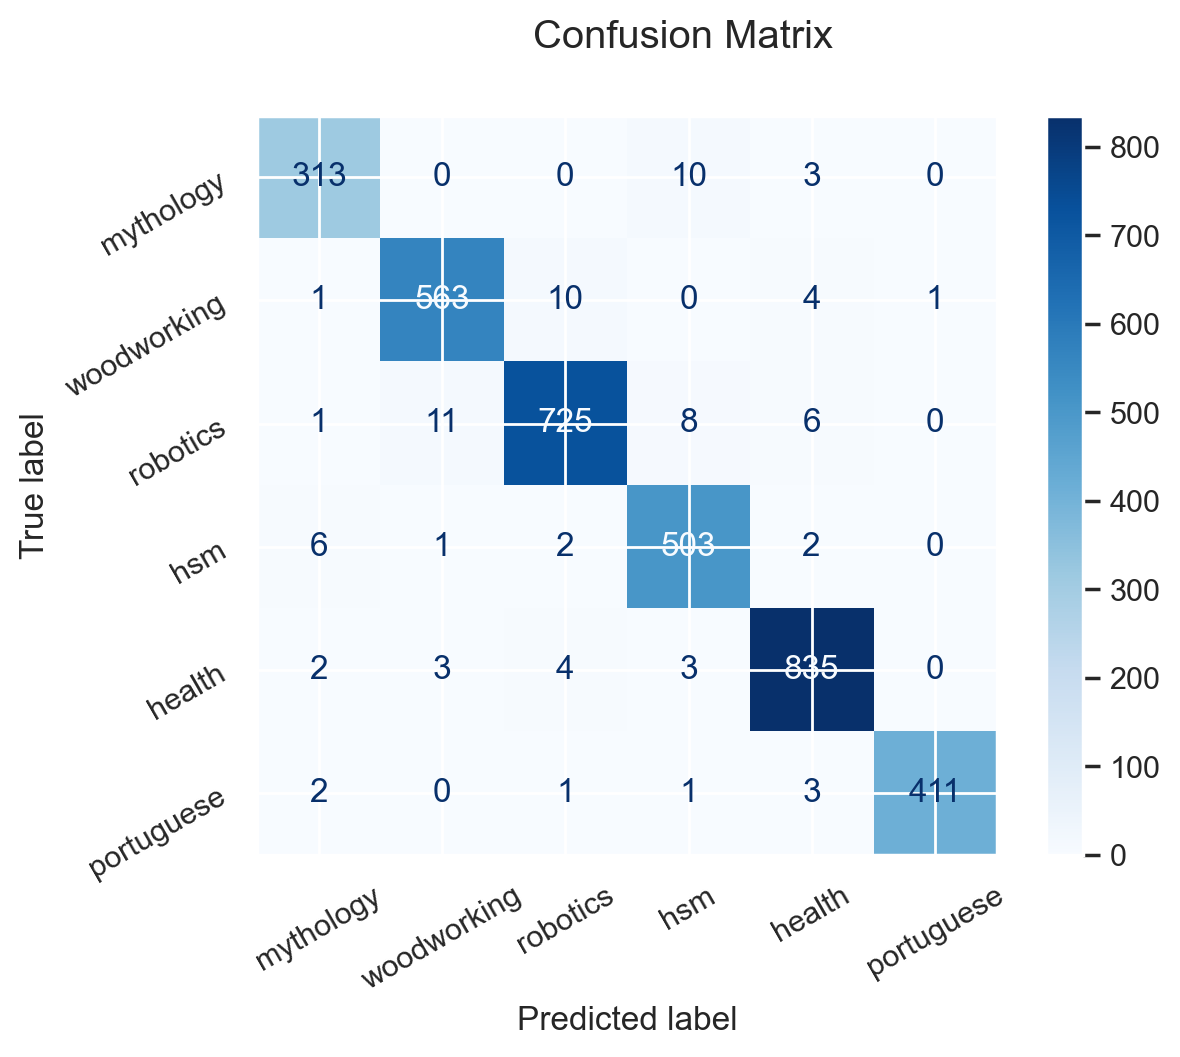

In [59]:
disp = metrics.ConfusionMatrixDisplay.from_estimator(
    model_LogisticRegression, xp_valid_filtered, y_valid, cmap=plt.cm.Blues,display_labels=CORPORA
)

disp.figure_.suptitle("Confusion Matrix")
plt.xticks(rotation=30)
plt.yticks(rotation=30)
plt.show()

In [60]:
print(metrics.classification_report(y_valid, prediction,target_names=CORPORA))

              precision    recall  f1-score   support

   mythology       0.96      0.96      0.96       326
 woodworking       0.97      0.97      0.97       579
    robotics       0.98      0.97      0.97       751
         hsm       0.96      0.98      0.97       514
      health       0.98      0.99      0.98       847
  portuguese       1.00      0.98      0.99       418

    accuracy                           0.98      3435
   macro avg       0.97      0.97      0.97      3435
weighted avg       0.98      0.98      0.98      3435



____